In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from functions import polyeig
plt.rcParams["figure.facecolor"] = "white"

# sine DVR
Let $\psi_n(z) = \sqrt{\frac{2}{\pi}}\sin(\frac{n\pi}{2}(z+1)), n=1,\cdots,N$ be the orthorgonal functions. Then the "coordinate basis" functions is given by

$$ u_j(z) = w_j\sum_{n=1}^N \psi_n(z)\psi_n^*(z_j) $$

where $w_j$ is the j-th weight for the selected quadrature rule and $u_j$ satisfy the Kronecker delta property
$$ u_j(x_k) = \delta_{jk} $$

Now the solution becomes
$$ \xi(z) = \sum_{n=1}^{N} a_n u_n(z) $$

Text(0.5, 1.0, '$ \\int_0^\\pi u_i(x)u_j(x) $')

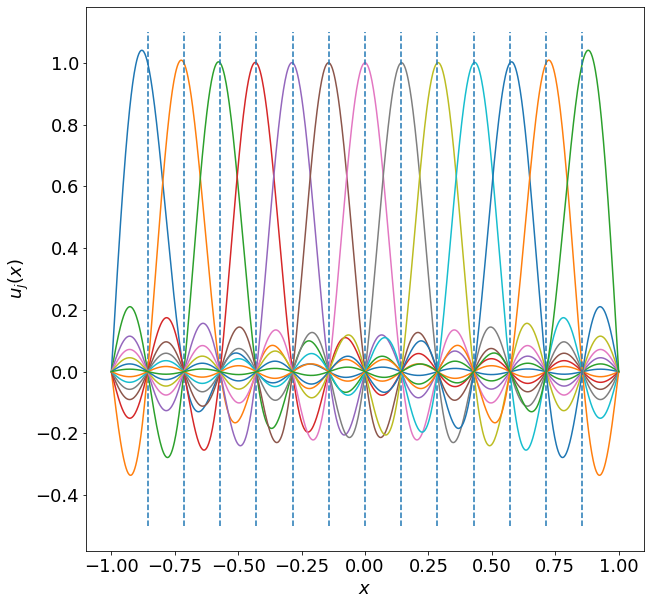

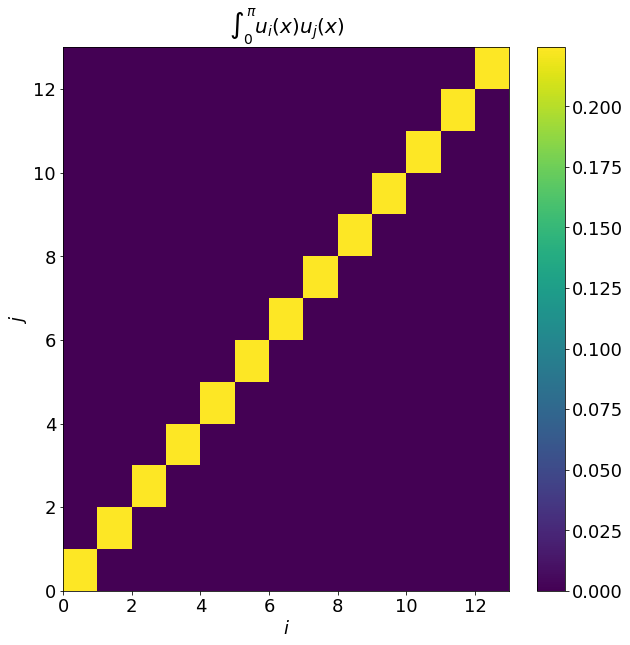

In [2]:
def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s


N = 13
xq = np.arange(1,N+1)*np.pi/(N+1)  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
xq = xq*2/np.pi - 1
psi = lambda x,n: np.sqrt(2/np.pi)*np.sin(n*np.pi/2*(x+1))

def u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

plt.figure()
x = np.linspace(-1,1,1000)
for j in range(N):
    plt.plot(x, u(x,j))
    plt.vlines(xq[j], -0.5,1.1,linestyles='--')
plt.ylabel("$u_j(x)$")
plt.xlabel("$x$")

plt.figure()
integrals = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
plt.pcolormesh(integrals)
plt.colorbar()
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.title("$ \int_0^\pi u_i(x)u_j(x) $")

### Try it on Smolyakov2005

In [3]:
N = 13
L = 10
xq = np.arange(1,N+1)*np.pi/(N+1)  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
xq = xq*2/np.pi - 1
psi = lambda x,n: np.sqrt(2/np.pi)*np.sin(n*np.pi/2*(x+1))
psi_p = lambda x,n: np.sqrt(np.pi/2)*n*np.cos(n*np.pi/2*(x+1)) 

def u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)
    return wq[j]*s

x = np.linspace(-1,1,1000)
f = lambda x: 10*np.exp(-(L*x)**2)

F = np.zeros((N,N))
H = np.zeros((N,N))
I = np.eye(N)
O = np.zeros_like(I)

c = quad(lambda x: u(x,0)*u(x,0), xq,wq)

for i in range(N):
    for j in range(N):
        F[i,j] = quad(lambda x: u(x,i)*f(x)*u(x,j), xq,wq)
        H[i,j] = quad(lambda x: u_p(x,i)*u_p(x,j)/c - u(x,i)*f(x)**2*u(x,j), xq,wq)

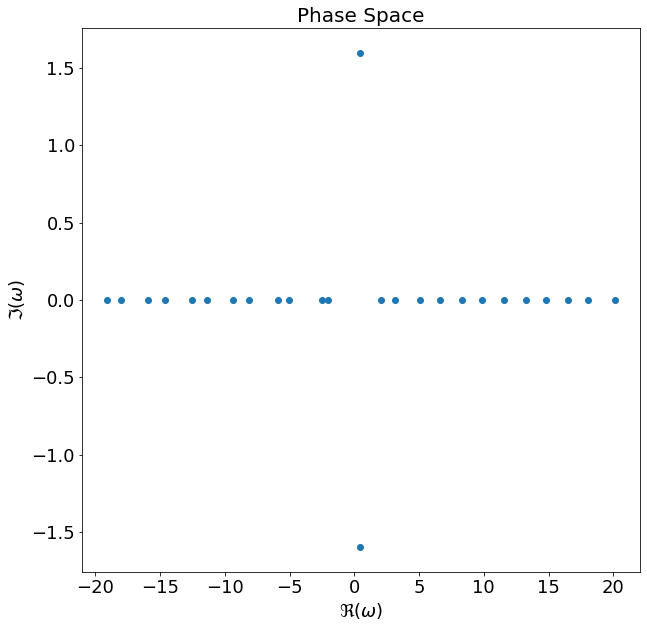

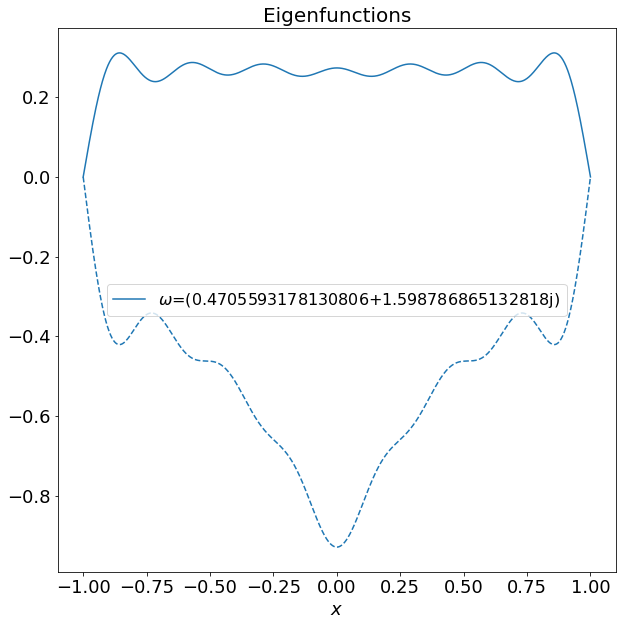

In [4]:
# finite-element + linear eigenvalue problem
A = np.block([[O,I],[H,2*F]])
omega,C = np.linalg.eig(A)

# sort
ind = np.argsort(np.imag(omega))[::-1]
omega = omega[ind]
C = C[:N,ind]/c 

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

plt.figure()
i = 0
v = 0
for n in range(N):
    v += C[n,i]*u(x,n)
line = plt.plot(x, np.real(v), label=f"$\omega$={omega[i]}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();

## Try it on our problem

In [5]:
N = 10
xq = np.arange(1,N+1)*np.pi/(N+1)  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
xq = xq*2/np.pi - 1
psi = lambda x,n: np.sqrt(2/np.pi)*np.sin(n*np.pi/2*(x+1))
psi_p = lambda x,n: np.sqrt(np.pi/2)*n*np.cos(n*np.pi/2*(x+1)) 

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s

def u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)
    return wq[j]*s


# magnetic field, B, and velocity profile, M
B0 = 1
R = 1.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))
W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts
# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )
#x = np.linspace(-1,1,201)
x = np.arange(-1,1,1/(2*(N+1)))

Text(0, 0.5, '$\\Im(\\omega)$')

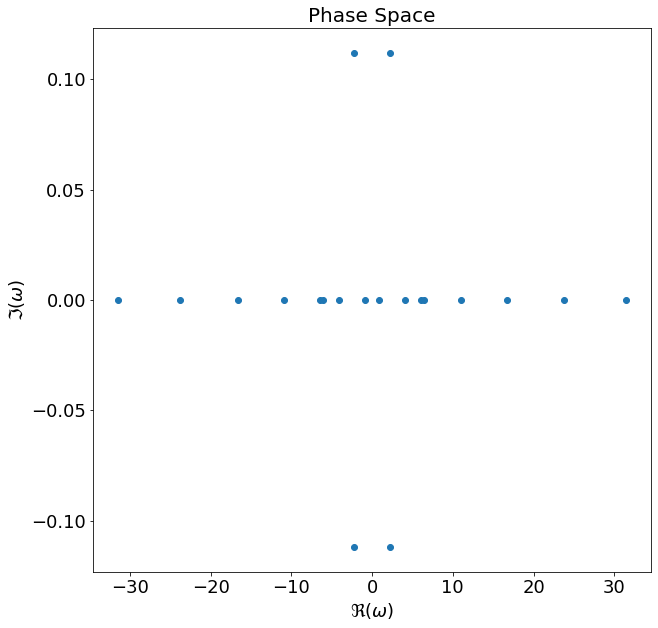

In [6]:
v0 = 1.5

A2 = np.zeros((N,N), dtype=complex)
A1 = np.zeros((N,N), dtype=complex)
A0 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A2[i,j] = quad(lambda x: u(x,i)*u(x,j),xq,wq)
        A1[i,j] = 2j*v0*quad(lambda x: u(x,i)*u_p(x,j),xq,wq)
        A0[i,j] = -(1-v0**2)*quad(lambda x: u_p(x,i)*u_p(x,j),xq,wq)

C,omega = polyeig(A0,A1,A2)

plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

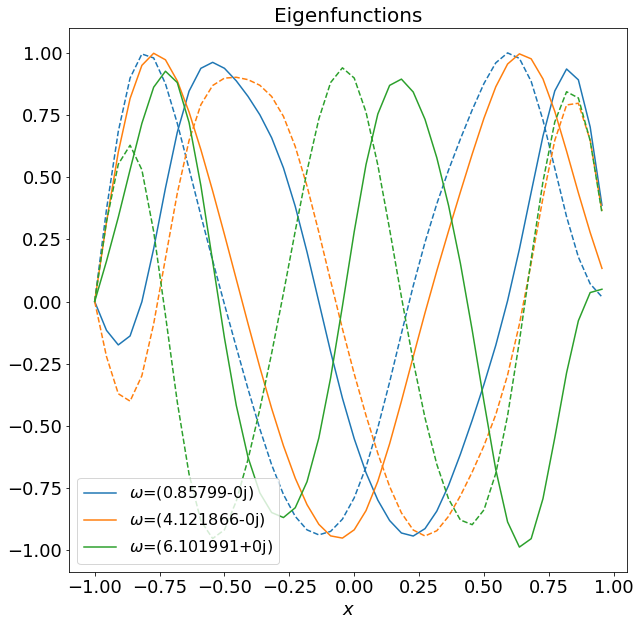

In [7]:
selection = (np.real(omega) > 0) & (np.abs(np.imag(omega)) < 0.01)
omega_ = omega[selection]
C_ = C[:,selection]

# sort 
ind = np.argsort(np.real(omega_))
omega_ = omega_[ind]
C_ = C[:,ind]

plt.figure()
for i in range(3):
    v = 0
    for n in range(N):
        v += C_[n,i]*u(x,n)
    line = plt.plot(x, np.real(v), label=f"$\omega$={np.around(omega_[i],6)}")
    plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();

# sinc DVR

In [8]:
from scipy.special import sinc

In [59]:
N = 10
xq = np.arange(-10,11,1)  # quadrature points
wq = np.ones_like(xq) # quadrature weights
psi = lambda x,n: sinc(x+n-N/2)
def psi_p_single(x,n):
    if (x+n-N/2) != 0:
        return (np.pi*np.cos(np.pi*(x+n-N/2))*(x+n-N/2)-np.sin(np.pi*(x+n-N/2)))/(np.pi*(x+n-N/2)**2)
    else:
        return 0
psi_p = np.vectorize(psi_p_single)
f = lambda x: 10*np.exp(-x**2)

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    s = 0
    for xq_j, wq_j in zip(xq,wq):
        s += wq_j*func(xq_j)
    return s

In [60]:
H = np.zeros((N+1,N+1))
F = np.zeros((N+1,N+1))
I = np.eye(N+1)
O = np.zeros_like(I)
for i in range(N+1):
    for j in range(N+1):
        H[i,j] = quad(lambda x:psi_p(x,i)*psi_p(x,j)-psi(x,i)*f(x)**2*psi(x,j),xq,wq)
        F[i,j] = quad(lambda x:psi(x,i)*f(x)*psi(x,j),xq,wq)
A = np.block([[O,I],[H,2*F]])
omega,C = np.linalg.eig(A)

Text(0, 0.5, '$\\Im(\\omega)$')

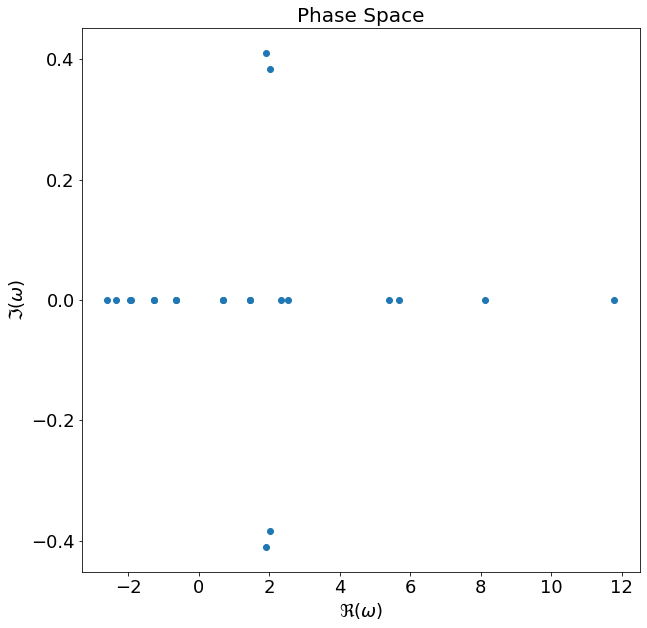

In [61]:
plt.figure()
plt.plot(np.real(omega), np.imag(omega), 'o')
plt.title("Phase Space")
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$")

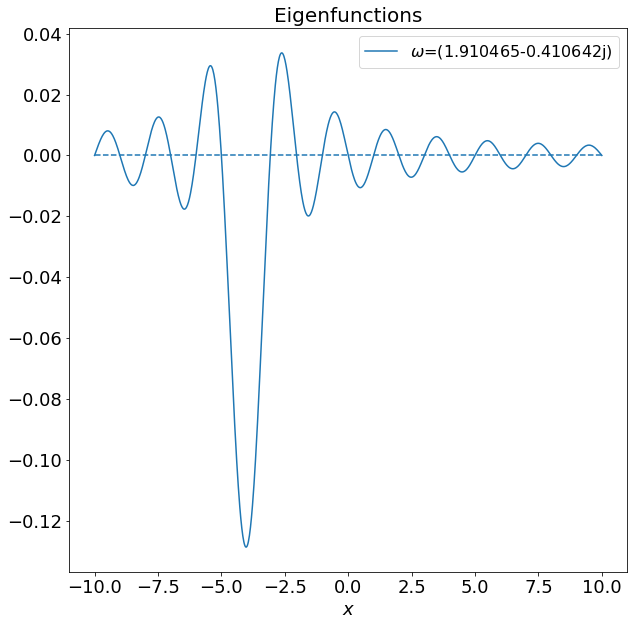

In [62]:
selection = (np.abs(np.imag(omega)) > 1e-9)
omega_ = omega[selection]
C_ = C[:,selection]

# sort 
ind = np.argsort(np.imag(omega_))
omega_ = omega_[ind]
C_ = C[:,ind]

plt.figure()
v = 0
for n in range(N):
    v += C_[n,0]*u(x,n)
line = plt.plot(x, np.real(v), label=f"$\omega$={np.around(omega_[0],6)}")
plt.plot(x, np.imag(v), '--', color=line[0]._color)
plt.xlabel("$x$")
plt.title("Eigenfunctions")
plt.legend();